In [56]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy.optimize import curve_fit
plt.style.use('./graph_preset.mplstyle')

In [70]:
class Fit_trans_refl:
    def __init__(self,i_angle,incpol,thickness):
        self.i_angle = i_angle
        self.incpol = incpol
        self.thickness = thickness

    def Fit_Func(self, n, losstan, d, freq_in, angle_i, incpol):
        c = 2.99792458e8
        num=len(d) #; the number of layer not including two ends
        const = np.sqrt((8.85418782e-12)/(4.*np.pi*1e-7)) #SI unit sqrt(dielectric const/permiability)
        # ;-----------------------------------------------------------------------------------
        # ; angle of refraction
        angle = np.zeros(num+2)          # ; angle[0]=incident angle
        angle[0] = angle_i
        for i in range(0,num+1): angle[i+1] = np.arcsin(np.sin(angle[i])*n[i]/n[i+1])
        # ;-----------------------------------------------------------------------------------
        # ; define the frequency span
        l = len(freq_in)
        output = np.zeros((3,l),'complex') # output = dcomplexarr(3,l)
        # ;-----------------------------------------------------------------------------------
        # ; define the effective thickness of each layer
        h = np.zeros(num,'complex')
        n_comparr = np.zeros(len(n),'complex')
        n_comparr[0] = complex(n[0], -0.5*n[0]*losstan[0])
        n_comparr[num+1] = complex(n[num+1], -0.5*n[num+1]*losstan[num+1])
        # ;-----------------------------------------------------------------------------------
        # ; for loop for various thickness of air gap between each layer
        for j in range(0,l):
            for i in range(0,num): 
                n_comparr[i+1] = complex(n[i+1], -0.5*n[i+1]*losstan[i+1])
                h[i] = n_comparr[i+1]*d[i]*np.cos(angle[i+1]) # ;effective thickness of 1st layer

            freq = freq_in[j]
            k = 2.*np.pi*freq/c

            # ;===========================================
            # ; Y: Y[0]=vacuum, Y[1]=1st layer..., Y[num+1]=end side
            Y = np.zeros(num+2,'complex')
            for i in range(0,num+2):
                if (incpol == 1):
                    Y[i] = const*n_comparr[i]*np.cos(angle[i])
                    cc = 1.
                if (incpol == -1):
                    Y[i] = const*n_comparr[i]/np.cos(angle[i])
                    cc = np.cos(angle[num+1])/np.cos(angle[0])

            # ;===========================================
            # ; define matrix for single layer
            m = np.identity((2),'complex')    # ; net matrix
            me = np.zeros((2,2),'complex') # ; me[0]=1st layer, ...
            for i in range(0,num):
                me[0,0] = complex(np.cos(k*h[i]), 0.)
                me[1,0] = complex(0., np.sin(k*h[i])/Y[i+1])
                me[0,1] = complex(0., np.sin(k*h[i])*Y[i+1])
                me[1,1] = complex(np.cos(k*h[i]), 0.)
                m = np.dot(m,me)

            r = (Y[0]*m[0,0]*cc+Y[0]*Y[num+1]*m[1,0]-m[0,1]*cc-Y[num+1]*m[1,1]) / (Y[0]*m[0,0]*cc+Y[0]*Y[num+1]*m[1,0]+m[0,1]*cc+Y[num+1]*m[1,1])
            t = 2.*Y[0] / (Y[0]*m[0,0]*cc+Y[0]*Y[num+1]*m[1,0]+m[0,1]*cc+Y[num+1]*m[1,1])

            output[0,j] = freq+0.j #; unit of [Hz]
            output[1,j] = r
            output[2,j] = t

        return output
    
    
    def Transmittance_FitIndex_1layer_incloss(self, freq, par0, par1): #[Hz]
        if par0 < 1: return 1e30
        if par1 < 0: return 1e30
    
        incpol = self.incpol
        d = np.array([self.thickness])
        angle_i = np.radians(self.i_angle)
        
        n = np.array([1.,par0,1.])
        losstan = np.array([0.,par1,0.])
        
        
        RT = self.Fit_Func( n, losstan, d, freq, angle_i, incpol)
        return np.abs(RT[2])**2
    
    
    def Reflectance_FitIndex_1layer_incloss(self, freq, par0, par1): #[Hz]
        if par0 < 1: return 1e30
        if par1 < 0: return 1e30
    
        incpol = self.incpol
        d = np.array([self.thickness])
        angle_i = np.radians(self.i_angle)

        n = np.array([1.,par0,1.])
        losstan = np.array([0.,par1,0.])
        
        RT = self.Fit_Func( n, losstan, d, freq, angle_i, incpol)
        return np.abs(RT[1])**2
    

def multiple_row_plot(rows, cols, row_ratios=None, col_ratios=None, figsize=(8,12)):
    """
    Create a grid of subplots with adjustable row and column ratios and external figsize.

    Args:
        rows (int): Number of rows.
        cols (int): Number of columns.
        row_ratios (list, optional): Relative heights of rows.
        col_ratios (list, optional): Relative widths of columns.
        figsize (tuple, optional): Figure size (width, height). Default is (8, 12).

    Returns:
        list: List of subplot axes.
    """
    fig = plt.figure(figsize=figsize,dpi=100)
    gs = gridspec.GridSpec(
        rows,
        cols,
        height_ratios=row_ratios,
        width_ratios=col_ratios,
        hspace=0.0,
        wspace=0.0,
    )
    ax_grid = [plt.subplot(gs[i]) for i in range(rows)]
    for ax in ax_grid[:-1]:
        plt.setp(ax.get_xticklabels(), visible=False)
    return ax_grid

In [71]:
# initializtion
data = dict()

# select data
data['air_before'] = np.loadtxt('data/mockdata_air_after.csv', delimiter=',', dtype='float',skiprows=1)
data['sample'] =  np.loadtxt('data/mockdata_sample.csv', delimiter=',', dtype='float',skiprows=1)
data['air_after'] = np.loadtxt('data/mockdata_air_before.csv', delimiter=',', dtype='float',skiprows=1)

# check the data format
print(f"data keys   : {list(data.keys())}")
print(f"air_before: {data['air_before'].shape}")
print(f"sample    : {data['sample'].shape}")
print(f"air_after : {data['air_after'].shape}")

# convert the frequency from GHz to Hz
data['sample'][:,0] = data['sample'][:,0]*1e9

# convert from dB to Transmittance
data['air_before'][:,1] = 10**(data['air_before'][:,1]/10)
data['sample'][:,1] = 10**(data['sample'][:,1]/10)
data['sample'][:,2] = 10**(data['sample'][:,2]/10)
data['air_after'][:,1] = 10**(data['air_after'][:,1]/10)

# set initial parameters
incpol=-1 # (-1: p-polarization, 1: s-polarization)
inc_angle = 0 # incident angle [deg]
thickness = 2.1e-3 # thickness [m]
n_init = 3.047 # Refractive index
los_init = 0 # Loss tangent
# =================================

# param init
param_init = [n_init, los_init]

# Call a class functions
lib_functions = Fit_trans_refl(inc_angle,incpol,thickness)

data keys   : ['air_before', 'sample', 'air_after']
air_before: (1000, 2)
sample    : (1000, 3)
air_after : (1000, 2)


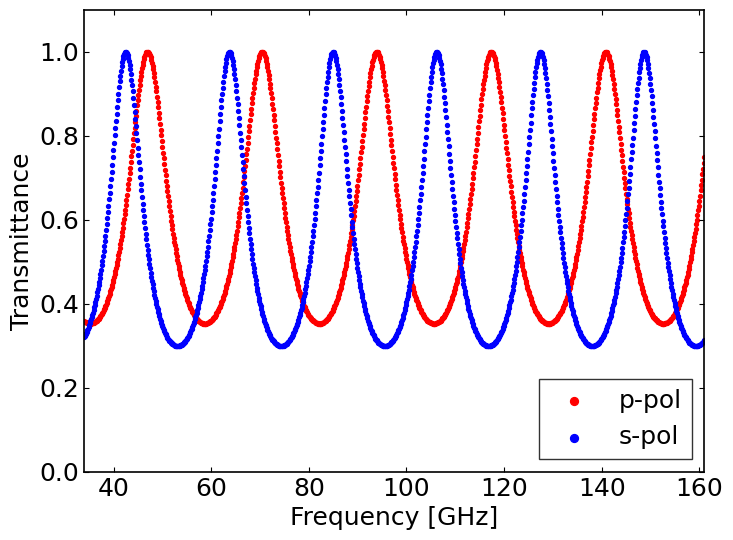

In [72]:
fig,ax = plt.subplots(figsize=(8,6))
ax.scatter(data['sample'][:,0]*10**(-9),data['sample'][:,1],label='p-pol',color='r',s=8)
ax.scatter(data['sample'][:,0]*10**(-9),data['sample'][:,2],label='s-pol',color='b',s=8)
ax.set_ylim(0,1.1)
ax.set_xlim(34,161)
ax.set_xlabel('Frequency [GHz]')
ax.set_ylabel('Transmittance')
ax.legend(loc='lower right')

In [73]:
popt_p, pcov_p = curve_fit(lib_functions.Transmittance_FitIndex_1layer_incloss,
                       data["sample"][:,0],
                       data["sample"][:,1],
                       p0=param_init, 
                       absolute_sigma=False,
                       maxfev=10000,
                       bounds=([2.5, 0], [4, 0.1]))

perr = np.sqrt(np.diag(pcov_p))

print("{:<10} {:>12} {:>12}".format("Index", "Value", "Error"))
for i, (p, err) in enumerate(zip(popt_p, perr)):
    print(f"{i:<10d} {p:12.8f} {err:12.8f}")

Index             Value        Error
0            3.04099998   0.00000002
1            0.00000016   0.00000000


Text(0, 0.5, '(Data - Fit) $\\times 10^6$')

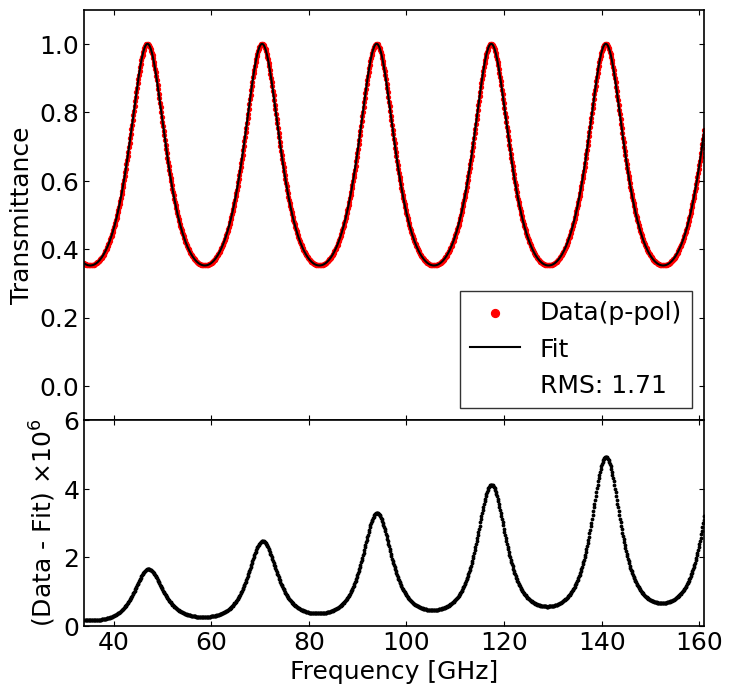

In [94]:
# Result plot
fitted_curve = lib_functions.Transmittance_FitIndex_1layer_incloss(data["sample"][:,0], *popt_p)
residual = data["sample"][:,1] - fitted_curve
residual_rms = np.sqrt(np.mean(residual**2))

ax = multiple_row_plot(2, 1, row_ratios=(2,1),figsize=(8, 8))
ax[0].scatter(data['sample'][:,0]*10**(-9),data['sample'][:,1],label='Data(p-pol)',color='r',s=8)
ax[0].plot(data['sample'][:,0]*10**(-9),fitted_curve,label='Fit',color='k')
ax[0].set_ylim(-0.1,1.1)
ax[0].set_xlim(34,161)
ax[0].set_xlabel('Frequency [GHz]')
ax[0].set_ylabel('Transmittance')
ax[0].scatter([],[],color='none',label=f"RMS: {residual_rms*10**6:.2f}")
ax[0].legend(loc='lower right')

ax[1].scatter(data['sample'][:,0]*10**(-9),residual*10**6,color='k',s=3)
ax[1].set_ylim(0,6)
ax[1].set_xlim(34,161)
ax[1].set_xlabel('Frequency [GHz]')
ax[1].set_ylabel(r'(Data - Fit) $\times 10^6$')
